In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':120})

In [2]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [3]:
obs_data = imputed_data[imputed_data.index < '2021-07-01']
obs_data = obs_data.asfreq('H')

In [4]:
scaler = MinMaxScaler()
scaler.fit(obs_data[['tmp_f_KDFW', 'north_load']])
imputed_data[['tmp_f_KDFW', 'north_load']] = scaler.transform(imputed_data)
imputed_data.fillna(0, inplace=True)

In [5]:
train_end = '2021-02-28 23:00:00-06:00'
val_start = '2021-03-01 00:00:00-06:00'
val_end = '2021-06-30 23:00:00-06:00'
test_start = '2021-07-01 00:00:00-06:00'

In [9]:
train_data = {}
train_outcomes = {}
for idx, _ in imputed_data.loc[:train_end].iterrows():
    if idx.year == 2017 and idx.month == 1 and idx.day == 1:
        pass
    else:
        train_data[idx] = {'load_lag_' + str(i): imputed_data.loc[idx - datetime.timedelta(hours=i)].north_load for i in range(1, 25)}
        for i in range(1, 25):
            train_data[idx]['tmp_lag_' + str(i)] = imputed_data.loc[idx - datetime.timedelta(hours = i)].tmp_f_KDFW
            
        train_data[idx]['Week_of_Year'] = idx.weekofyear
        train_data[idx]['Day_of_Week'] = idx.dayofweek
        train_data[idx]['Month'] = idx.month
        
        train_outcomes[idx] = imputed_data.loc[idx].north_load
        

In [10]:
train_data_df = pd.DataFrame.from_dict(train_data, orient='index')
train_outcomes_df = pd.DataFrame.from_dict(train_outcomes, orient='index', columns=['north_load_obs'])

In [12]:
clf = xgb.XGBRegressor(tree_method='hist', eval_metric=mean_absolute_error)
clf.fit(train_data_df, train_outcomes_df, eval_set=[(train_data_df, train_outcomes_df)])

[0]	validation_0-rmse:0.18475	validation_0-mean_absolute_error:0.16432
[1]	validation_0-rmse:0.13083	validation_0-mean_absolute_error:0.11585
[2]	validation_0-rmse:0.09334	validation_0-mean_absolute_error:0.08197
[3]	validation_0-rmse:0.06756	validation_0-mean_absolute_error:0.05846
[4]	validation_0-rmse:0.05002	validation_0-mean_absolute_error:0.04222
[5]	validation_0-rmse:0.03834	validation_0-mean_absolute_error:0.03114
[6]	validation_0-rmse:0.03074	validation_0-mean_absolute_error:0.02369
[7]	validation_0-rmse:0.02600	validation_0-mean_absolute_error:0.01879
[8]	validation_0-rmse:0.02301	validation_0-mean_absolute_error:0.01562
[9]	validation_0-rmse:0.02124	validation_0-mean_absolute_error:0.01369
[10]	validation_0-rmse:0.02009	validation_0-mean_absolute_error:0.01245
[11]	validation_0-rmse:0.01924	validation_0-mean_absolute_error:0.01167
[12]	validation_0-rmse:0.01877	validation_0-mean_absolute_error:0.01117
[13]	validation_0-rmse:0.01832	validation_0-mean_absolute_error:0.01081
[1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7f83902944c0>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [13]:
in_sample_preds = clf.predict(train_data_df)
in_sample_preds = pd.DataFrame(in_sample_preds, columns=['preds'])
in_sample_preds.index = pd.to_datetime(train_data_df.index)

<AxesSubplot:>

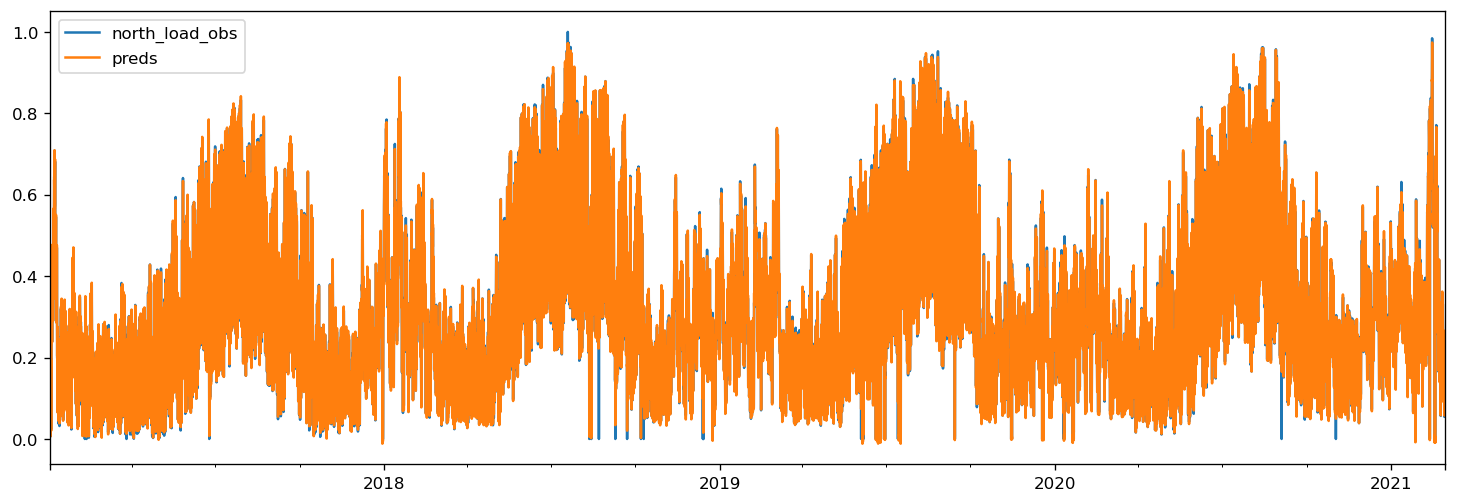

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_outcomes_df.plot(ax=ax)
in_sample_preds.plot(ax=ax)

### Step-Forward Forecast Validation

In [17]:
target_cov = pd.DataFrame(index=imputed_data.loc[val_start:val_end].index, columns=['load_lag_' + str(i) for i in range(1, 25)] + 
                                                                                          ['tmp_lag_' + str(i) for i in range(1, 25)])
combined = pd.concat([train_data_df, target_cov])
prev_load = train_outcomes_df.loc[train_end].values[0]

forecasts = []

for idx, row in combined.loc[val_start:val_end].iterrows():
    combined.loc[idx, ['load_lag_' + str(i) for i in range(2, 25)]] = list(combined.loc[idx - datetime.timedelta(hours=1), 'load_lag_1':'load_lag_23'])
    combined.loc[idx, 'load_lag_1'] = prev_load
    combined.loc[idx, ['tmp_lag_' + str(i) for i in range(2, 25)]] = list(combined.loc[idx - datetime.timedelta(hours=1), 'tmp_lag_1':'tmp_lag_23'])
    combined.loc[idx, 'tmp_lag_1'] = imputed_data.loc[idx - datetime.timedelta(hours=1)].tmp_f_KDFW
    
    combined.loc[idx, 'Week_of_Year'] = idx.weekofyear
    combined.loc[idx, 'Day_of_Week'] = idx.dayofweek
    combined.loc[idx, 'Month'] = idx.month
    
    prev_load = clf.predict(combined.loc[idx].to_numpy().reshape(1, -1))[0]
    forecasts.append(prev_load)

In [19]:
forecasts = pd.DataFrame(forecasts, index=imputed_data.loc[val_start:val_end].index, columns=['forecasts'])

In [21]:
mean_absolute_error(imputed_data.loc[val_start:val_end].north_load, forecasts.forecasts)

0.049730322708086985

<AxesSubplot:xlabel='date_time'>

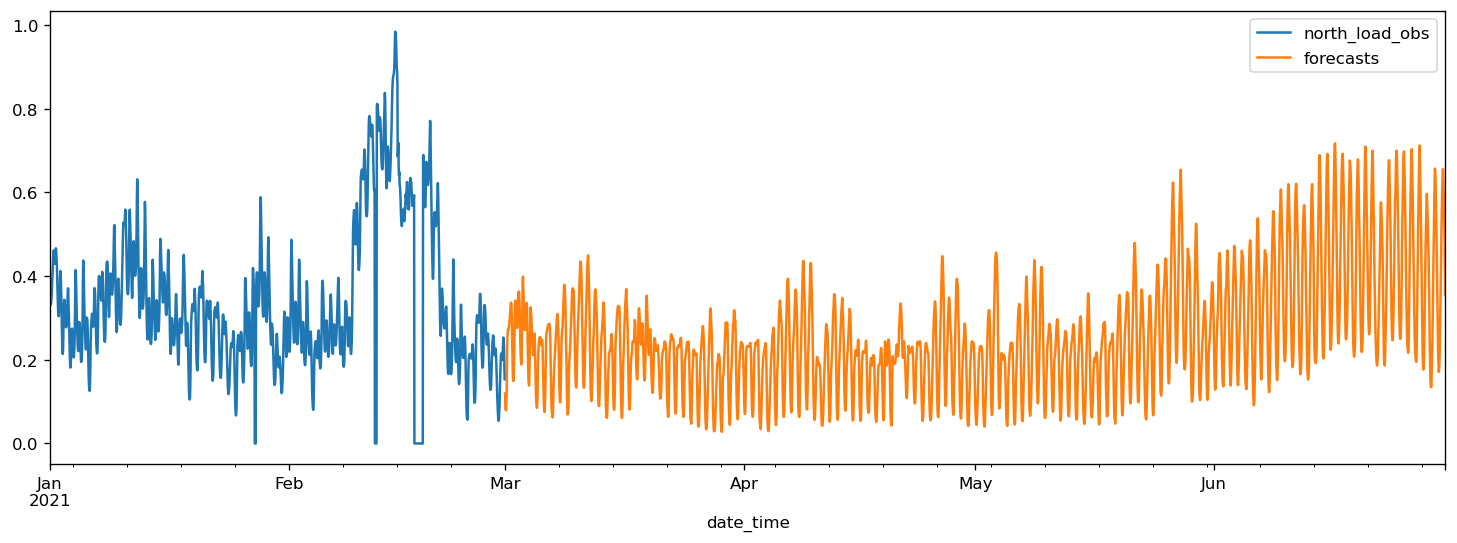

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_outcomes_df.loc['2021'].plot(ax=ax)
forecasts.plot(ax=ax)

### Retrain with all training data

In [23]:
train_data = {}
train_outcomes = {}
for idx, _ in imputed_data.loc[:val_end].iterrows():
    if idx.year == 2017 and idx.month == 1 and idx.day == 1:
        pass
    else:
        train_data[idx] = {'load_lag_' + str(i): imputed_data.loc[idx - datetime.timedelta(hours=i)].north_load for i in range(1, 25)}
        for i in range(1, 25):
            train_data[idx]['tmp_lag_' + str(i)] = imputed_data.loc[idx - datetime.timedelta(hours = i)].tmp_f_KDFW
            
        train_data[idx]['Week_of_Year'] = idx.weekofyear
        train_data[idx]['Day_of_Week'] = idx.dayofweek
        train_data[idx]['Month'] = idx.month
        
        train_outcomes[idx] = imputed_data.loc[idx].north_load
        

In [24]:
train_data_df = pd.DataFrame.from_dict(train_data, orient='index')
train_outcomes_df = pd.DataFrame.from_dict(train_outcomes, orient='index', columns=['north_load_obs'])

In [25]:
clf = xgb.XGBRegressor(tree_method='hist', eval_metric=mean_absolute_error)
clf.fit(train_data_df, train_outcomes_df, eval_set=[(train_data_df, train_outcomes_df)])

[0]	validation_0-rmse:0.18578	validation_0-mean_absolute_error:0.16579
[1]	validation_0-rmse:0.13148	validation_0-mean_absolute_error:0.11678
[2]	validation_0-rmse:0.09369	validation_0-mean_absolute_error:0.08258
[3]	validation_0-rmse:0.06767	validation_0-mean_absolute_error:0.05880
[4]	validation_0-rmse:0.04996	validation_0-mean_absolute_error:0.04239
[5]	validation_0-rmse:0.03810	validation_0-mean_absolute_error:0.03116
[6]	validation_0-rmse:0.03044	validation_0-mean_absolute_error:0.02364
[7]	validation_0-rmse:0.02565	validation_0-mean_absolute_error:0.01871
[8]	validation_0-rmse:0.02261	validation_0-mean_absolute_error:0.01548
[9]	validation_0-rmse:0.02069	validation_0-mean_absolute_error:0.01345
[10]	validation_0-rmse:0.01948	validation_0-mean_absolute_error:0.01216
[11]	validation_0-rmse:0.01869	validation_0-mean_absolute_error:0.01133
[12]	validation_0-rmse:0.01821	validation_0-mean_absolute_error:0.01086
[13]	validation_0-rmse:0.01776	validation_0-mean_absolute_error:0.01050
[1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7f83902944c0>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

## Apply to Test Data

In [27]:
target_cov = pd.DataFrame(index=imputed_data.loc[test_start:].index, columns=['load_lag_' + str(i) for i in range(1, 25)] + 
                                                                                          ['tmp_lag_' + str(i) for i in range(1, 25)])
combined = pd.concat([train_data_df, target_cov])
prev_load = train_outcomes_df.loc[val_end].values[0]

test_forecasts = []

for idx, row in combined.loc[test_start:].iterrows():
    combined.loc[idx, ['load_lag_' + str(i) for i in range(2, 25)]] = list(combined.loc[idx - datetime.timedelta(hours=1), 'load_lag_1':'load_lag_23'])
    combined.loc[idx, 'load_lag_1'] = prev_load
    combined.loc[idx, ['tmp_lag_' + str(i) for i in range(2, 25)]] = list(combined.loc[idx - datetime.timedelta(hours=1), 'tmp_lag_1':'tmp_lag_23'])
    combined.loc[idx, 'tmp_lag_1'] = imputed_data.loc[idx - datetime.timedelta(hours=1)].tmp_f_KDFW
    
    combined.loc[idx, 'Week_of_Year'] = idx.weekofyear
    combined.loc[idx, 'Day_of_Week'] = idx.dayofweek
    combined.loc[idx, 'Month'] = idx.month
    
    prev_load = clf.predict(combined.loc[idx].to_numpy().reshape(1, -1))[0]
    test_forecasts.append(prev_load)

In [28]:
test_forecasts = pd.DataFrame(test_forecasts, index=imputed_data.loc[test_start:].index, columns=['test_forecasts'])

<AxesSubplot:xlabel='date_time'>

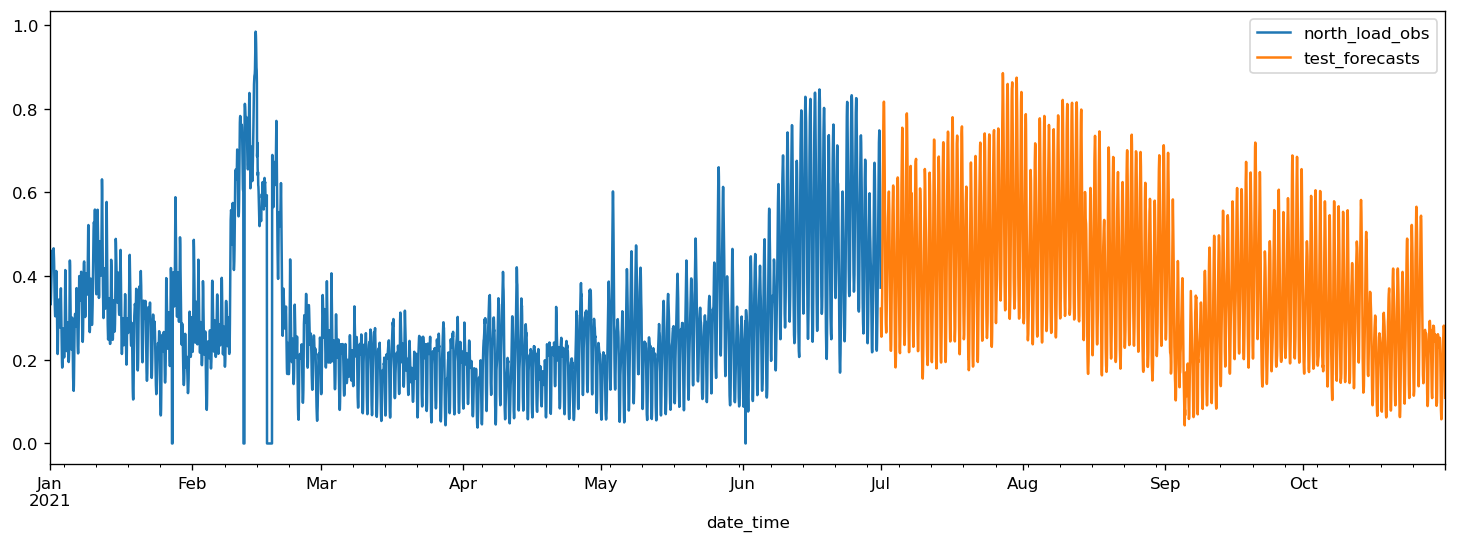

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_outcomes_df.loc['2021'].plot(ax=ax)
test_forecasts.plot(ax=ax)

## Re-plot with data scaled _back_ to MW

<AxesSubplot:xlabel='date_time'>

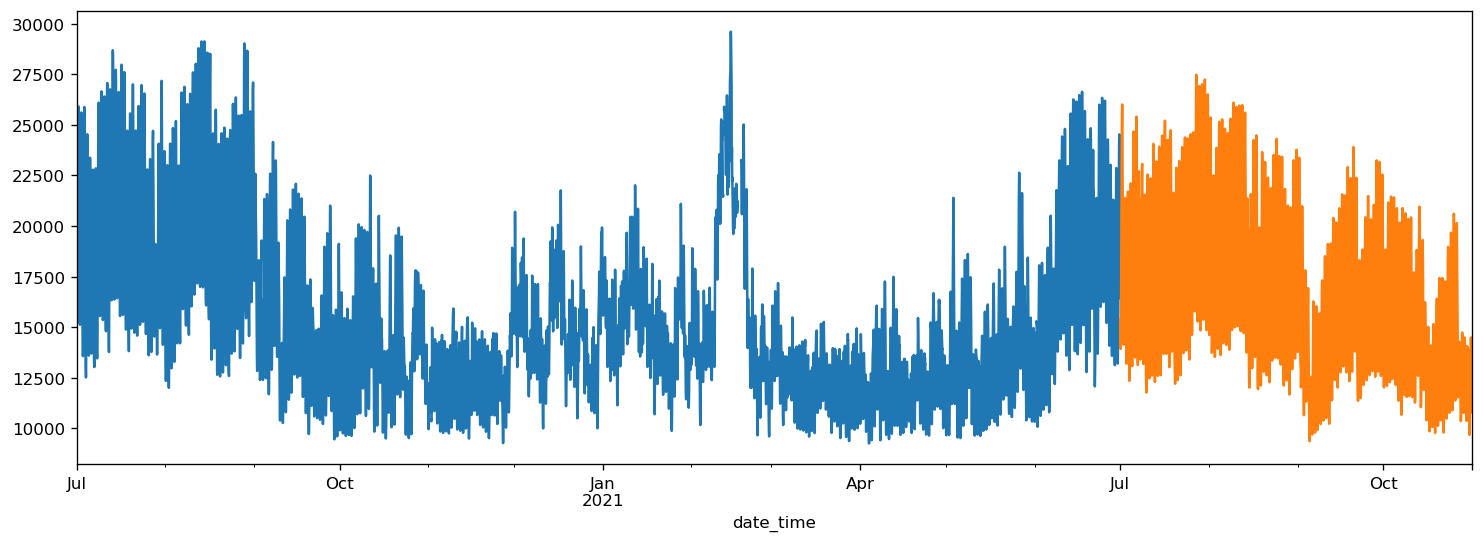

In [40]:
dummy_forecasts = test_forecasts.copy(deep=True)
dummy_forecasts['tmp_dummy'] = np.zeros(len(dummy_forecasts))

dummy_forecasts = dummy_forecasts[['tmp_dummy', 'test_forecasts']]

inv_trans_test_forecasts = pd.DataFrame(scaler.inverse_transform(dummy_forecasts), index=imputed_data.loc['2021-07-01':].index, columns=['tmp_dummy', 'test_forecasts'])

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
obs_data.loc['2020-07-01':].north_load.plot(ax=ax)
inv_trans_test_forecasts.test_forecasts.plot(ax=ax)